# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [5]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [6]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.recurrent import LSTM
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [9]:

train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:


def generator(source_path, folder_list, batch_size,x,y,z):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [x for x in range(0,x)] #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    temp = imresize(image,(y,z))
                                        
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            print("Batch: ",num_batches+1,"Index:", batch_size)
            batch_size = len(folder_list) - (batch_size*num_batches)
            batch_data = np.zeros((batch_size,x,y,z,3))
            batch_labels = np.zeros((batch_size,5))
            for folder in range(batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    temp = imresize(image,(y,z))
                    
                    batch_data[folder,idx,:,:,0] = (temp[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (temp[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (temp[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)


# training sequences = 663
# validation sequences = 100


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Base Conv3D network without BatchNormalization

In [12]:

model = Sequential()
model.add(Conv3D(16, (3,3,3), padding='same',
                 input_shape=[20, 120, 120, 3]))
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(Activation('relu'))

model.add(Conv3D(32, (3,3,3)))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5))
model.add(Activation('softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
optimiser = optimizers.Adam()  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_7 (Activation)    (None, 20, 120, 120, 16)  0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 18, 118, 118, 16)  6928      
_________________________________________________________________
activation_8 (Activation)    (None, 18, 118, 118, 16)  0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 9, 59, 59, 16)     0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9, 59, 59, 16)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 9, 59, 59, 32)     13856     
__________

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [14]:
x = 20 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 20 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
num_epochs =15
model_1=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
20
Epoch 1/15
34/34 [==============================] - 133s 4s/step - loss: 2.2212 - categorical_accuracy: 0.1825 - val_loss: 1.6091 - val_categorical_accuracy: 0.1800

Epoch 00001: saving model to model_init_2020-08-1706_03_15.641591/model-00001-2.23629-0.18703-1.60912-0.18000.h5
Epoch 2/15
34/34 [==============================] - 11s 330ms/step - loss: 1.6108 - categorical_accuracy: 0.1863 - val_loss: 1.6082 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model_init_2020-08-1706_03_15.641591/model-00002-1.61085-0.18627-1.60821-0.23000.h5
Epoch 3/15
34/34 [==============================] - 11s 330ms/step - loss: 1.6098 - categorical_accuracy: 0.1961 - val_loss: 1.6087 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_init_2020-08-1706_03_15.641591/model-00003-1.60978-0.19608-1.60869-0.21

In [18]:
# list all data in history
print(model_1.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy', 'lr'])


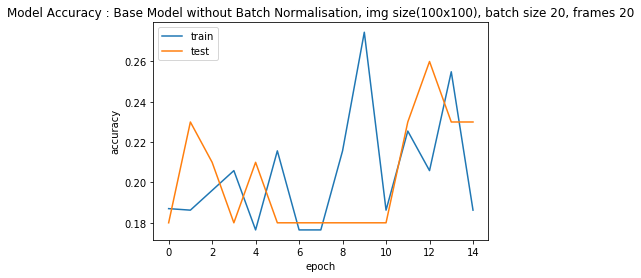

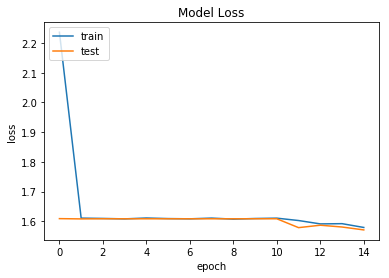

In [19]:
# summarize for accuracy
plt.plot(model_1.history['categorical_accuracy'])
plt.plot(model_1.history['val_categorical_accuracy'])
plt.title('Model Accuracy : Base Model without Batch Normalisation, img size(100x100), batch size 20, frames 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_1.history['loss'])
plt.plot(model_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Too many trainable parameters - 38,588,021

#### Conv3D model with 38 million parameters has 25% accuracy & could not run for more than 15 epochs , throws OOM error with more epochs for training so reducing total number of parameters.

### Conv3D Model with BatchNormalisation , reducing number of filters, adding more layers to network & dropout

In [20]:

inp_shape = (20, 120, 120, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number pf filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [21]:
optimiser = optimizers.Adam()  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 120, 8)   32        
_________________________________________________________________
activation_13 (Activation)   (None, 20, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 60, 60, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 60, 60, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 60, 60, 16)    64        
_________________________________________________________________
activation_14 (Activation)   (None, 10, 60, 60, 16)    0         
__________

In [23]:
x = 20 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 20 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
num_epochs =60
model_2=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
Epoch 1/60
34/34 [==============================] - 56s 2s/step - loss: 3.6910 - categorical_accuracy: 0.2598 - val_loss: 5.2310 - val_categorical_accuracy: 0.2500

Epoch 00001: saving model to model_init_2020-08-1706_03_15.641591/model-00001-3.75282-0.25792-5.23099-0.25000.h5
Epoch 2/60
34/34 [==============================] - 9s 259ms/step - loss: 2.4470 - categorical_accuracy: 0.2157 - val_loss: 1.3324 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-08-1706_03_15.641591/model-00002-2.44703-0.21569-1.33238-0.44000.h5
Epoch 3/60
34/34 [==============================] - 10s 283ms/step - loss: 2.2133 - categorical_accuracy: 0.2549 - val_loss: 1.5508 - val_categorical_accuracy: 0.3400

Epoch 00003: saving model to model_init_2020-08-1706_03_15.641591/model-00003-2.21334-0.25490-1.55085-0.3400

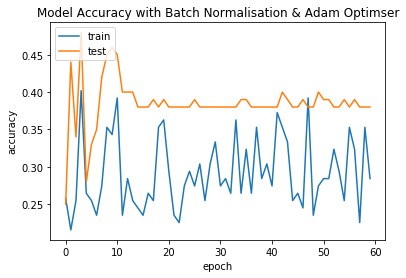

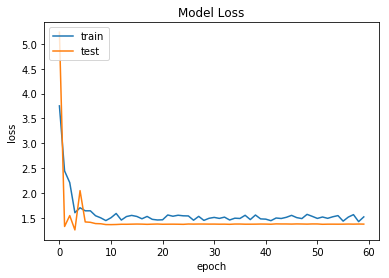

In [25]:
# summarize for accuracy
plt.plot(model_2.history['categorical_accuracy'])
plt.plot(model_2.history['val_categorical_accuracy'])
plt.title('Model Accuracy with Batch Normalisation & Adam Optimser')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_2.history['loss'])
plt.plot(model_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Trainable parameters reduced to 1.8 million. Accuracy on training data is 35% & accuracy on Validation data is 38%. Model is underfitting. 

### Reducing Image size to 100x100

In [26]:

inp_shape = (20, 100, 100, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number of filters 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [27]:
optimiser = optimizers.Adam()  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 100, 100, 8)   656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 100, 100, 8)   32        
_________________________________________________________________
activation_17 (Activation)   (None, 20, 100, 100, 8)   0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 50, 50, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 50, 50, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 50, 50, 16)    64        
_________________________________________________________________
activation_18 (Activation)   (None, 10, 50, 50, 16)    0         
__________

In [30]:
x = 20 # number of frames
y = 100 # image width
z = 100 # image height
batch_size = 20 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [31]:
num_epochs =60
model_3=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/trainEpoch 1/60
 ; batch size = 20
34/34 [==============================] - 50s 1s/step - loss: 1.4134 - categorical_accuracy: 0.3473 - val_loss: 1.3872 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-08-1706_03_15.641591/model-00001-1.40657-0.35596-1.38724-0.35000.h5
Epoch 2/60
34/34 [==============================] - 9s 252ms/step - loss: 1.4062 - categorical_accuracy: 0.3824 - val_loss: 1.3751 - val_categorical_accuracy: 0.3500

Epoch 00002: saving model to model_init_2020-08-1706_03_15.641591/model-00002-1.40616-0.38235-1.37510-0.35000.h5
Epoch 3/60
34/34 [==============================] - 9s 277ms/step - loss: 1.3875 - categorical_accuracy: 0.3922 - val_loss: 1.3592 - val_categorical_accuracy: 0.3600

Epoch 00003: saving model to model_init_2020-08-1706_03_15.641591/model-00003-1.38747-0.39216-1.35919-0.36000

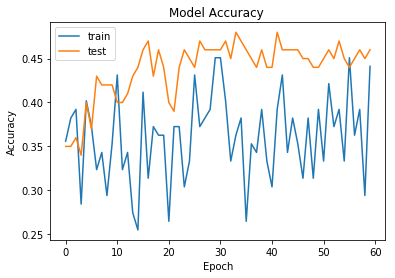

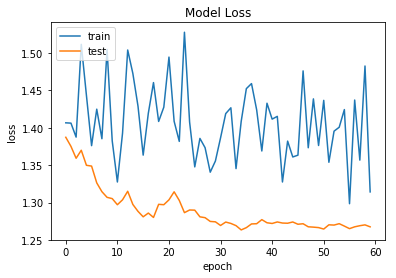

In [32]:
# summarize for accuracy
plt.plot(model_3.history['categorical_accuracy'])
plt.plot(model_3.history['val_categorical_accuracy'])
plt.title('Model Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_3.history['loss'])
plt.plot(model_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

With 1.3 million Trainable parameters, accuracy is very low and model is underfitting.

### Changing Image Size to 80x80

In [10]:

inp_shape = (20, 80, 80, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))

model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [11]:
optimiser = optimizers.Adam()  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 80, 80, 8)     656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 80, 80, 8)     32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 80, 80, 8)     0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 40, 40, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 40, 40, 16)    3472      
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 40, 40, 16)    64        
_________________________________________________________________
activation_2 (Activation)    (None, 10, 40, 40, 16)    0         
__________

In [12]:
x = 20 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 20 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [13]:

num_epochs =60
model_4=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 20
Source path =  /mnt/disks/user/project/PROJECT/Project_data/trainEpoch 1/60
 ; batch size = 20
34/34 [==============================] - 50s 1s/step - loss: 2.7803 - categorical_accuracy: 0.2458 - val_loss: 1.3926 - val_categorical_accuracy: 0.4200

Epoch 00001: saving model to model_init_2020-08-1706_51_58.866497/model-00001-2.81514-0.23529-1.39261-0.42000.h5
Epoch 2/60
34/34 [==============================] - 8s 250ms/step - loss: 2.2018 - categorical_accuracy: 0.3431 - val_loss: 1.7518 - val_categorical_accuracy: 0.3700

Epoch 00002: saving model to model_init_2020-08-1706_51_58.866497/model-00002-2.20179-0.34314-1.75176-0.37000.h5
Epoch 3/60
34/34 [==============================] - 9s 262ms/step - loss: 2.4814 - categorical_accuracy: 0.1765 - val_loss: 2.5371 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2020-08-1706_51_58.866497/model-00003-2.48144-0.17647-2.53713-0.24000

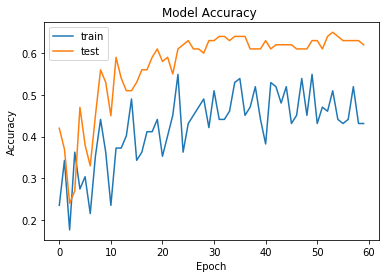

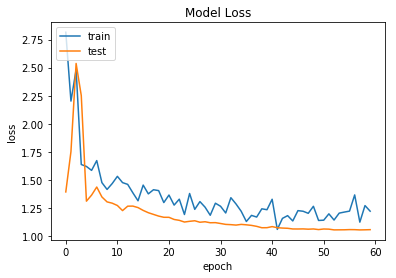

In [14]:
# summarize for accuracy
plt.plot(model_4.history['categorical_accuracy'])
plt.plot(model_4.history['val_categorical_accuracy'])
plt.title('Model Accuracy ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_4.history['loss'])
plt.plot(model_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

979k Trainable parameters. Model is underfitting

### Increasing batch size to 30, reducing dense layer neurons to 256,128 , removing dropouts. Adding LR 0.001

In [15]:

inp_shape = (20, 80, 80, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(256, activation='relu'))
#model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu'))
#model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [16]:
learning_rate = 0.001
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 80, 80, 8)     656       
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 80, 80, 8)     32        
_________________________________________________________________
activation_5 (Activation)    (None, 20, 80, 80, 8)     0         
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 10, 40, 40, 8)     0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 10, 40, 40, 16)    3472      
_________________________________________________________________
batch_normalization_6 (Batch (None, 10, 40, 40, 16)    64        
_________________________________________________________________
activation_6 (Activation)    (None, 10, 40, 40, 16)    0         
__________

In [17]:
x = 20 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 30 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [18]:
num_epochs =60
model_5=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 30
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 30
Epoch 1/60
23/23 [==============================] - 49s 2s/step - loss: 1.4936 - categorical_accuracy: 0.3551 - val_loss: 1.9450 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model_init_2020-08-1706_51_58.866497/model-00001-1.51243-0.35596-1.94495-0.28000.h5
Epoch 2/60
23/23 [==============================] - 5s 201ms/step - loss: 1.6870 - categorical_accuracy: 0.4058 - val_loss: 1.2708 - val_categorical_accuracy: 0.4750

Epoch 00002: saving model to model_init_2020-08-1706_51_58.866497/model-00002-1.68696-0.40580-1.27079-0.47500.h5
Epoch 3/60
23/23 [==============================] - 5s 238ms/step - loss: 1.4822 - categorical_accuracy: 0.3623 - val_loss: 1.3746 - val_categorical_accuracy: 0.5250

Epoch 00003: saving model to model_init_2020-08-1706_51_58.866497/model-00003-1.48221-0.36232-1.37455-0.52500

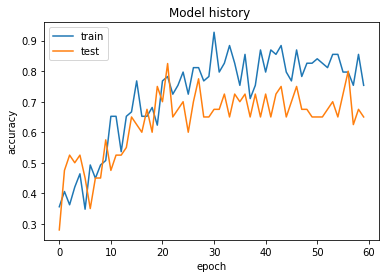

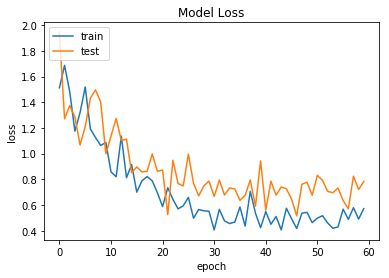

In [19]:
# summarize for accuracy
plt.plot(model_5.history['categorical_accuracy'])
plt.plot(model_5.history['val_categorical_accuracy'])
plt.title('Model history ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_5.history['loss'])
plt.plot(model_5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

470k trainable parameters. Training Accuracy - 79% & Val Accuracy - 70%

### Reducing Learning Rate from 0.001 to 0.0002

In [21]:

inp_shape = (20, 80, 80, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(256, activation='relu'))
#model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu'))
#model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [22]:
learning_rate = 0.0002
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 20, 80, 80, 8)     656       
_________________________________________________________________
batch_normalization_9 (Batch (None, 20, 80, 80, 8)     32        
_________________________________________________________________
activation_9 (Activation)    (None, 20, 80, 80, 8)     0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 10, 40, 40, 8)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 10, 40, 40, 16)    3472      
_________________________________________________________________
batch_normalization_10 (Batc (None, 10, 40, 40, 16)    64        
_________________________________________________________________
activation_10 (Activation)   (None, 10, 40, 40, 16)    0         
__________

In [23]:
x = 20 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 30 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
num_epochs =60
model_6=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path = Source path =  /mnt/disks/user/project/PROJECT/Project_data/train /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 30
Epoch 1/60
 ; batch size = 30
23/23 [==============================] - 49s 2s/step - loss: 1.5437 - categorical_accuracy: 0.3667 - val_loss: 1.2923 - val_categorical_accuracy: 0.4400

Epoch 00001: saving model to model_init_2020-08-1706_51_58.866497/model-00001-1.53209-0.36802-1.29228-0.44000.h5
Epoch 2/60
23/23 [==============================] - 4s 157ms/step - loss: 1.1850 - categorical_accuracy: 0.5217 - val_loss: 1.1766 - val_categorical_accuracy: 0.4750

Epoch 00002: saving model to model_init_2020-08-1706_51_58.866497/model-00002-1.18505-0.52174-1.17661-0.47500.h5
Epoch 3/60
23/23 [==============================] - 6s 243ms/step - loss: 1.2275 - categorical_accuracy: 0.5072 - val_loss: 1.4732 - val_categorical_accuracy: 0.3750

Epoch 00003: saving model to model_init_2020-08-1706_51_58.866497/model-00003-1.22749-0.50725-1.47323-0.37500

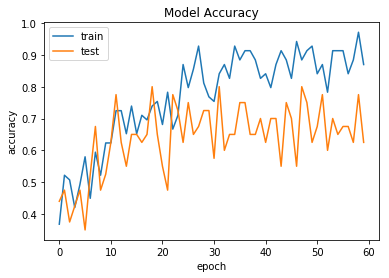

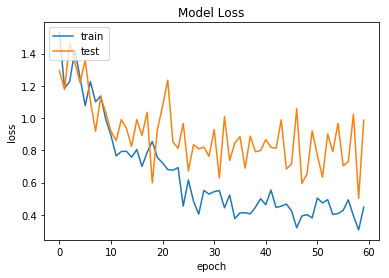

In [25]:
plt.plot(model_6.history['categorical_accuracy'])
plt.plot(model_6.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_6.history['loss'])
plt.plot(model_6.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy b/w Train & Val data varying a lot. Accuracy: Train 86%, Val 63% . Model is overfitting

### Adding another layer 

In [26]:

inp_shape = (20, 80, 80, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(256, activation='relu'))
#model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu'))
#model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

In [27]:
learning_rate = 0.0002
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 80, 80, 8)     656       
_________________________________________________________________
batch_normalization_13 (Batc (None, 20, 80, 80, 8)     32        
_________________________________________________________________
activation_13 (Activation)   (None, 20, 80, 80, 8)     0         
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 10, 40, 40, 8)     0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 10, 40, 40, 16)    3472      
_________________________________________________________________
batch_normalization_14 (Batc (None, 10, 40, 40, 16)    64        
_________________________________________________________________
activation_14 (Activation)   (None, 10, 40, 40, 16)    0         
__________

In [28]:
x = 20 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 30 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [29]:
num_epochs =60
model_7=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 30
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 30Epoch 1/60

23/23 [==============================] - 50s 2s/step - loss: 1.5969 - categorical_accuracy: 0.3284 - val_loss: 1.3133 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-08-1706_51_58.866497/model-00001-1.60756-0.31523-1.31326-0.46000.h5
Epoch 2/60
23/23 [==============================] - 3s 150ms/step - loss: 1.4627 - categorical_accuracy: 0.3913 - val_loss: 1.5791 - val_categorical_accuracy: 0.4250

Epoch 00002: saving model to model_init_2020-08-1706_51_58.866497/model-00002-1.46267-0.39130-1.57908-0.42500.h5
Epoch 3/60
23/23 [==============================] - 5s 221ms/step - loss: 1.6377 - categorical_accuracy: 0.2174 - val_loss: 1.1119 - val_categorical_accuracy: 0.6250

Epoch 00003: saving model to model_init_2020-08-1706_51_58.866497/model-00003-1.63767-0.21739-1.11188-0.62500

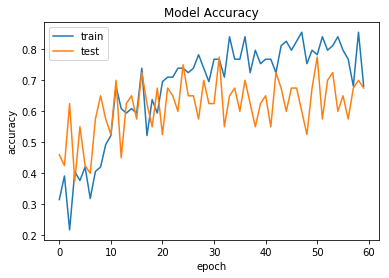

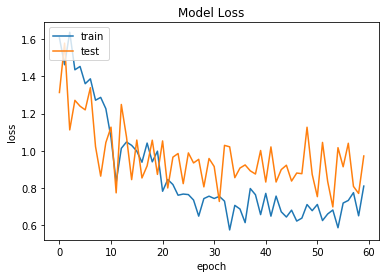

In [30]:
plt.plot(model_7.history['categorical_accuracy'])
plt.plot(model_7.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_7.history['loss'])
plt.plot(model_7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

477k parameters

### Batch size 25, Removing added layer & setting LR to Auto

In [34]:
inp_shape = (30, 80, 80, 3)
#model 2
model_2 = Sequential()

model_2.add(Conv3D(8, #number of filters 
                 kernel_size=(3,3,3), 
                 input_shape=inp_shape,
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(16, #Number of filters, 
                 kernel_size=(3,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(32, #Number of filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

model_2.add(Conv3D(64, #Number pf filters 
                 kernel_size=(1,3,3), 
                 padding='same'))
model_2.add(BatchNormalization())
model_2.add(Activation('relu'))
model_2.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
model_2.add(Flatten())

model_2.add(Dense(256, activation='relu'))
#model_2.add(Dropout(0.5))

model_2.add(Dense(128, activation='relu'))
#model_2.add(Dropout(0.5))

#softmax layer
model_2.add(Dense(5, activation='softmax'))

#learning_rate = 0.0002
#optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_22 (Conv3D)           (None, 30, 80, 80, 8)     656       
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 80, 80, 8)     32        
_________________________________________________________________
activation_22 (Activation)   (None, 30, 80, 80, 8)     0         
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 15, 40, 40, 8)     0         
_________________________________________________________________
conv3d_23 (Conv3D)           (None, 15, 40, 40, 16)    3472      
_________________________________________________________________
batch_normalization_23 (Batc (None, 15, 40, 40, 16)    64        
_________________________________________________________________
activation_23 (Activation)   (None, 15, 40, 40, 16)    0         
__________

In [35]:
x = 30 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 25 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR =  ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, cooldown=1, verbose=1)  # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [36]:
num_epochs =60
model_9=model_2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 25
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 25
Epoch 1/60
27/27 [==============================] - 125s 5s/step - loss: 1.5195 - categorical_accuracy: 0.3728 - val_loss: 1.1190 - val_categorical_accuracy: 0.5400

Epoch 00001: saving model to model_init_2020-08-1706_51_58.866497/model-00001-1.52767-0.37255-1.11901-0.54000.h5
Epoch 2/60
27/27 [==============================] - 36s 1s/step - loss: 1.1065 - categorical_accuracy: 0.5271 - val_loss: 1.6044 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2020-08-1706_51_58.866497/model-00002-1.10649-0.52707-1.60443-0.45000.h5
Epoch 3/60
27/27 [==============================] - 38s 1s/step - loss: 1.1142 - categorical_accuracy: 0.5043 - val_loss: 1.2699 - val_categorical_accuracy: 0.4500

Epoch 00003: saving model to model_init_2020-08-1706_51_58.866497/model-00003-1.11421-0.50427-1.26986-0.45000.h5

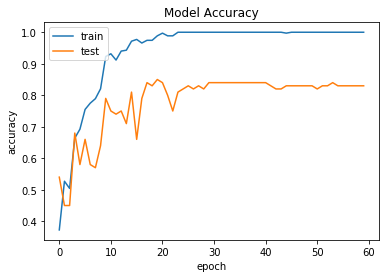

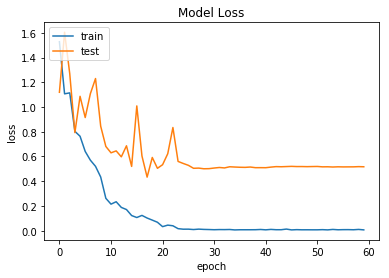

In [37]:
plt.plot(model_9.history['categorical_accuracy'])
plt.plot(model_9.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_9.history['loss'])
plt.plot(model_9.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving Model : Conv3D increased batch size(50), frames(25), img size(90x90)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 50
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 50
Epoch 1/40
14/14 [==============================] - 167s 12s/step - loss: 1.5030 - categorical_accuracy: 0.3602 - val_loss: 1.2289 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-08-1315_35_15.875103/model-00001-1.51933-0.35897-1.22888-0.46000.h5
Epoch 2/40
14/14 [==============================] - 25s 2s/step - loss: 1.0983 - categorical_accuracy: 0.5385 - val_loss: 1.3291 - val_categorical_accuracy: 0.4700

Epoch 00002: saving model to model_init_2020-08-1315_35_15.875103/model-00002-1.09826-0.53846-1.32912-0.47000.h5
Epoch 3/40
14/14 [==============================] - 20s 1s/step - loss: 1.1694 - categorical_accuracy: 0.5165 - val_loss: 1.0569 - val_categorical_accuracy: 0.5600

Epoch 00003: saving model to model_init_2020-08-1315_35_15.875103/model-00003-1.16943-0.51648-1.05686-0.56000.h

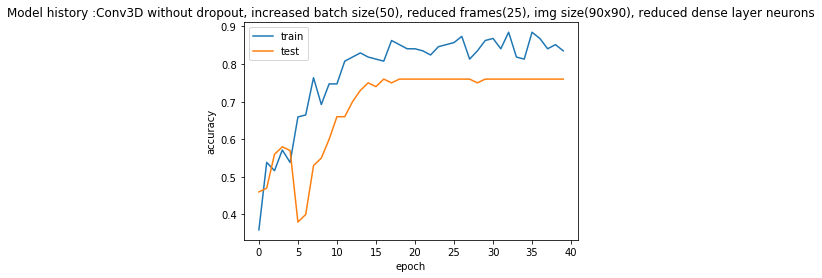

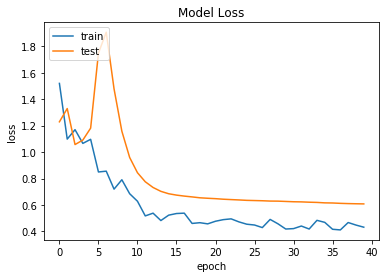

# CNN+RNN Model


##### Image size (120,120) , batch size 10 , Sample CNN+RNN Model

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D, MaxPooling3D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers.recurrent import LSTM, GRU

In [13]:
#write your model here
featuremap = [8,16,32,64]
dense = [128,64,5]
classes = 5
frames=30
# Input
input_shape=(30, 120, 120, 3)

model_A1 = Sequential()

model_A1.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model_A1.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
model_A1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_A1.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
model_A1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_A1.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
model_A1.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_A1.add(TimeDistributed(BatchNormalization()))
model_A1.add(Dropout(0.25))

model_A1.add(TimeDistributed(Flatten()))

model_A1.add(Dense(dense[0], activation='relu'))
model_A1.add(Dropout(0.25))
model_A1.add(Dense(dense[1], activation='relu'))
model_A1.add(Dropout(0.25))

model_A1.add(GRU(128, return_sequences=False))
model_A1.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [14]:
# Experimenting with Adam optimiser
learning_rate = 0.001
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_A1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 7, 64)      0         
__________

In [15]:
x = 30 # number of frames
y = 120 # image width
z = 120 # image height
batch_size = 10 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [16]:
num_epochs =30
model_12=model_A1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - 171s 3s/step - loss: 1.3197 - categorical_accuracy: 0.4204 - val_loss: 1.4770 - val_categorical_accuracy: 0.4600

Epoch 00001: saving model to model_init_2020-08-1712_36_05.989731/model-00001-1.31940-0.41780-1.47696-0.46000.h5
Epoch 2/30
67/67 [==============================] - 25s 374ms/step - loss: 1.1926 - categorical_accuracy: 0.5622 - val_loss: 3.2788 - val_categorical_accuracy: 0.2600

Epoch 00002: saving model to model_init_2020-08-1712_36_05.989731/model-00002-1.19263-0.56219-3.27877-0.26000.h5
Epoch 3/30
67/67 [==============================] - 28s 418ms/step - loss: 1.2790 - categorical_accuracy: 0.4975 - val_loss: 1.5097 - val_categorical_accuracy: 0.4400

Epoch 00003: saving model to model_init_2020-08-1712_36_05.989731/model-00003-1.27903-0.49751-1.50972-0.44

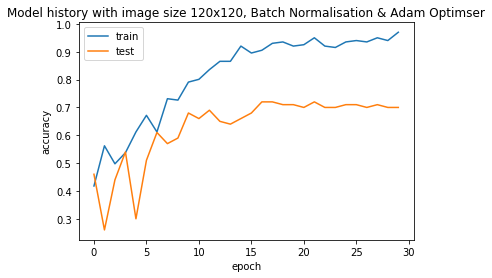

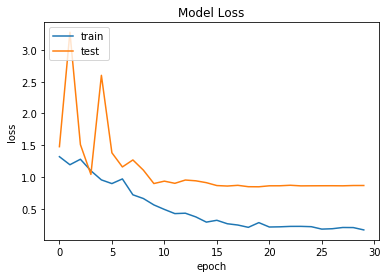

In [17]:
plt.plot(model_12.history['categorical_accuracy'])
plt.plot(model_12.history['val_categorical_accuracy'])
plt.title('Model history with image size 120x120, Batch Normalisation & Adam Optimser')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_12.history['loss'])
plt.plot(model_12.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##### Model is clearly overfitting with max categorical_accuracy=97% and max val_categorical_accuracy=72%

##### Experimenting with image size(80,80) and increased dropouts

In [18]:
featuremap = [8,16,32,64]
dense = [128,64,5]
classes = 5
frames=30
# Input
input_shape=(30, 80, 80, 3)

model_CR2 = Sequential()

model_CR2.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model_CR2.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
model_CR2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR2.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
model_CR2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR2.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
model_CR2.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR2.add(TimeDistributed(BatchNormalization()))
model_CR2.add(Dropout(0.3))

model_CR2.add(TimeDistributed(Flatten()))

model_CR2.add(Dense(dense[0], activation='relu'))
model_CR2.add(Dropout(0.3))
model_CR2.add(Dense(dense[1], activation='relu'))
model_CR2.add(Dropout(0.3))

model_CR2.add(GRU(128, return_sequences=False))
model_CR2.add(Dense(classes, activation='softmax')) # using Softmax as last layer


In [19]:
# Experimenting with Adam optimiser
learning_rate = 0.001
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_CR2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_CR2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_10 (TimeDis (None, 30, 40, 40, 8)     224       
_________________________________________________________________
time_distributed_11 (TimeDis (None, 30, 40, 40, 16)    1168      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 20, 20, 16)    0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 20, 20, 32)    4640      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 10, 10, 32)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 10, 10, 64)    8256      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 5, 5, 64)      0         
__________

In [20]:
x = 30 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 10 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [21]:
num_epochs =30
model_12=model_CR2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 10
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train Epoch 1/30
; batch size = 10
67/67 [==============================] - 72s 1s/step - loss: 1.4203 - categorical_accuracy: 0.3715 - val_loss: 3.2032 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2020-08-1712_36_05.989731/model-00001-1.42733-0.36501-3.20325-0.16000.h5
Epoch 2/30
67/67 [==============================] - 23s 344ms/step - loss: 1.4728 - categorical_accuracy: 0.4080 - val_loss: 1.4210 - val_categorical_accuracy: 0.4100

Epoch 00002: saving model to model_init_2020-08-1712_36_05.989731/model-00002-1.47284-0.40796-1.42103-0.41000.h5
Epoch 3/30
67/67 [==============================] - 25s 367ms/step - loss: 1.4118 - categorical_accuracy: 0.4030 - val_loss: 1.3339 - val_categorical_accuracy: 0.4600

Epoch 00003: saving model to model_init_2020-08-1712_36_05.989731/model-00003-1.41180-0.40299-1.33387-0.460

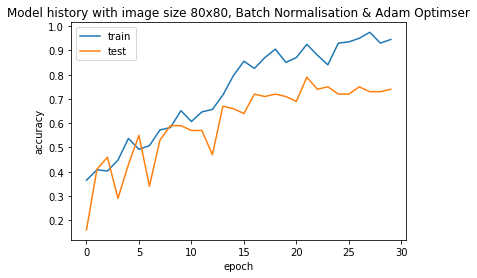

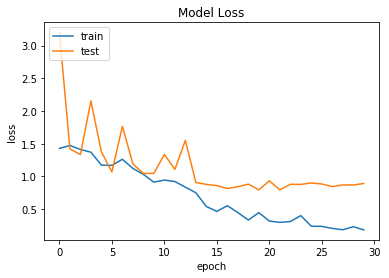

In [22]:
plt.plot(model_12.history['categorical_accuracy'])
plt.plot(model_12.history['val_categorical_accuracy'])
plt.title('Model history with image size 80x80, Batch Normalisation & Adam Optimser')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_12.history['loss'])
plt.plot(model_12.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Slight better results with max categorical_accuracy=94% and max val_categorical_accuracy=75% but model still looks like overfitting

###### Experiment with increased filters and batch_size 20

In [23]:
nb_featuremap = [16,32,64,128]
nb_dense = [256,128,5]
nb_classes = 5
frames=30
# Input
input_shape=(30, 80, 80, 3)

model_CR3 = Sequential()

model_CR3.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model_CR3.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
model_CR3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR3.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
model_CR3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR3.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
model_CR3.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR3.add(TimeDistributed(BatchNormalization()))
model_CR3.add(Dropout(0.3))

model_CR3.add(TimeDistributed(Flatten()))

model_CR3.add(Dense(dense[0], activation='relu'))
model_CR3.add(Dropout(0.3))
model_CR3.add(Dense(dense[1], activation='relu'))
model_CR3.add(Dropout(0.3))

model_CR3.add(GRU(128, return_sequences=False))
model_CR3.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [24]:
# Experimenting with Adam optimiser
learning_rate = 0.001
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_CR3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_CR3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_19 (TimeDis (None, 30, 40, 40, 8)     224       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 30, 40, 40, 16)    1168      
_________________________________________________________________
time_distributed_21 (TimeDis (None, 30, 20, 20, 16)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 30, 20, 20, 32)    4640      
_________________________________________________________________
time_distributed_23 (TimeDis (None, 30, 10, 10, 32)    0         
_________________________________________________________________
time_distributed_24 (TimeDis (None, 30, 10, 10, 64)    8256      
_________________________________________________________________
time_distributed_25 (TimeDis (None, 30, 5, 5, 64)      0         
__________

In [25]:
x = 30 # number of frames
y = 80 # image width
z = 80 # image height
batch_size = 20 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
num_epochs =30
model_14=model_CR3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/valSource path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 20
 ; batch size = 20
Epoch 1/30
34/34 [==============================] - 73s 2s/step - loss: 1.4071 - categorical_accuracy: 0.3723 - val_loss: 2.2219 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2020-08-1712_36_05.989731/model-00001-1.40754-0.38160-2.22189-0.30000.h5
Epoch 2/30
34/34 [==============================] - 13s 385ms/step - loss: 1.4757 - categorical_accuracy: 0.4510 - val_loss: 1.3731 - val_categorical_accuracy: 0.4000

Epoch 00002: saving model to model_init_2020-08-1712_36_05.989731/model-00002-1.47569-0.45098-1.37309-0.40000.h5
Epoch 3/30
34/34 [==============================] - 13s 389ms/step - loss: 1.3419 - categorical_accuracy: 0.4804 - val_loss: 1.8847 - val_categorical_accuracy: 0.2400

Epoch 00003: saving model to model_init_2020-08-1712_36_05.989731/model-00003-1.34186-0.48039-1.88470-0.240

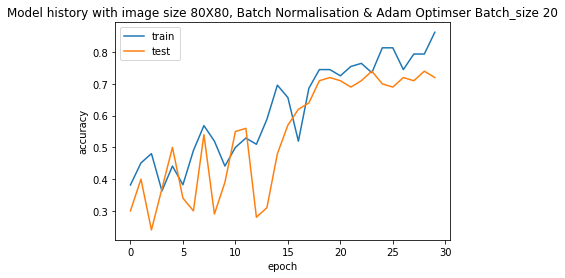

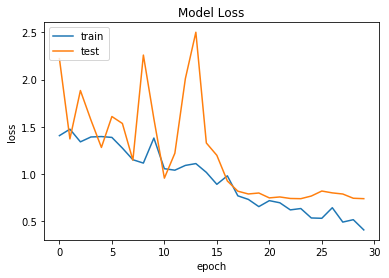

In [27]:
plt.plot(model_14.history['categorical_accuracy'])
plt.plot(model_14.history['val_categorical_accuracy'])
plt.title('Model history with image size 80X80, Batch Normalisation & Adam Optimser Batch_size 20')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_14.history['loss'])
plt.plot(model_14.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model with max categorical_accuracy=86% and max val_categorical_accuracy=75% but

###### Decreasing Learning rate from .001 to .0002 

In [34]:
#write your model here
featuremap = [16,32,64,128]
dense = [256,128,5]
classes = 5
frames=30
# Input
input_shape=(30,100,100, 3)

model_CR4 = Sequential()

model_CR4.add(TimeDistributed(Conv2D(featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=input_shape))


model_CR4.add(TimeDistributed(Conv2D(featuremap[1], (3,3),padding='same', activation='relu')))
model_CR4.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR4.add(TimeDistributed(Conv2D(featuremap[2], (3,3),padding='same', activation='relu')))
model_CR4.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR4.add(TimeDistributed(Conv2D(featuremap[3], (2,2),padding='same', activation='relu')))
model_CR4.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model_CR4.add(TimeDistributed(BatchNormalization()))
model_CR4.add(Dropout(0.25))

model_CR4.add(TimeDistributed(Flatten()))

model_CR4.add(Dense(dense[0], activation='relu'))
model_CR4.add(Dropout(0.25))
model_CR4.add(Dense(dense[1], activation='relu'))
model_CR4.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
model_CR4.add(GRU(128, return_sequences=False))
model_CR4.add(Dense(classes, activation='softmax')) # using Softmax as last layer

In [35]:
# Experimenting with Adam optimiser
learning_rate = 0.0002
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model_CR4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_A1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 30, 60, 60, 8)     224       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 15, 15, 64)    8256      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 7, 7, 64)      0         
__________

In [36]:
x = 30 # number of frames
y = 100 # image width
z = 100 # image height
batch_size = 10 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [37]:
num_epochs =30
model_15=model_CR4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Source path =  /mnt/disks/user/project/PROJECT/Project_data/val /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 10
Epoch 1/30
; batch size = 10
67/67 [==============================] - 77s 1s/step - loss: 1.3585 - categorical_accuracy: 0.4020 - val_loss: 1.1952 - val_categorical_accuracy: 0.4800

Epoch 00001: saving model to model_init_2020-08-1712_36_05.989731/model-00001-1.36172-0.40271-1.19521-0.48000.h5
Epoch 2/30
67/67 [==============================] - 24s 352ms/step - loss: 1.1109 - categorical_accuracy: 0.5572 - val_loss: 1.6274 - val_categorical_accuracy: 0.4400

Epoch 00002: saving model to model_init_2020-08-1712_36_05.989731/model-00002-1.11093-0.55721-1.62742-0.44000.h5
Epoch 3/30
67/67 [==============================] - 26s 390ms/step - loss: 1.0170 - categorical_accuracy: 0.6070 - val_loss: 1.3391 - val_categorical_accuracy: 0.5000

Epoch 00003: saving model to model_init_2020-08-1712_36_05.989731/model-00003-1.01699-0.60697-1.33907-0.500

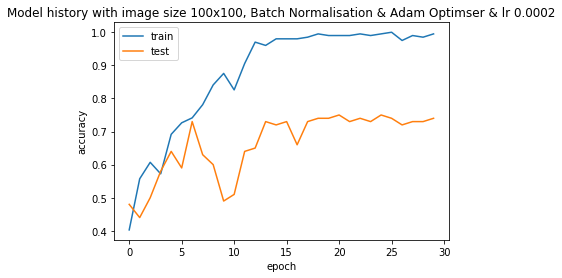

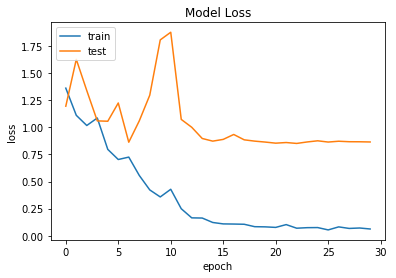

In [38]:
plt.plot(model_15.history['categorical_accuracy'])
plt.plot(model_15.history['val_categorical_accuracy'])
plt.title('Model history with image size 100x100, Batch Normalisation & Adam Optimser & lr 0.0002')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_15.history['loss'])
plt.plot(model_15.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transfer Learning with GRU - VGG16 Imagenet

In [8]:
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Add, Dense, Activation, TimeDistributed, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D

def get_model():
    
    base_model = VGG16(weights='imagenet', include_top=False)
    
        
    # Get the output from the base model 
    base_model_ouput = base_model.output
    print(base_model_ouput)

    print("base_model.input",base_model.input)
    input_layer = Input(shape=[20, 100, 100, 3])
    x = TimeDistributed(base_model)(input_layer)
    
    
    x=TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
    
    x=TimeDistributed(Flatten())(x)
    x=GRU(512)(x)
    
 
    x = Dense(256, activation='relu')(x)
  
    x = Dense(5, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=input_layer, outputs=x)

    return model
model=get_model()

58892288/58889256 [==============================] - 5s 0us/step
Tensor("block5_pool/MaxPool:0", shape=(?, ?, ?, 512), dtype=float32)
base_model.input Tensor("input_1:0", shape=(?, ?, ?, 3), dtype=float32)


In [9]:
learning_rate = 0.0002
optimiser = optimizers.Adam(lr=learning_rate)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 20, 100, 100, 3)   0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 3, 3, 512)     14714688  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 20, 1, 1, 512)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 20, 512)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 512)               1574400   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
fcnew (Dense)                (None, 5)                 1285      
Total para

In [10]:
x = 20 # number of frames
y = 100 # image width
z = 100 # image height
batch_size = 25 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [11]:
num_epochs =35
model_14=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 25
Source path =  /mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 25
Epoch 1/35
27/27 [==============================] - 153s 6s/step - loss: 1.6487 - categorical_accuracy: 0.2013 - val_loss: 1.5493 - val_categorical_accuracy: 0.3500

Epoch 00001: saving model to model_init_2020-08-1710_15_23.483396/model-00001-1.65027-0.20211-1.54930-0.35000.h5
Epoch 2/35
27/27 [==============================] - 46s 2s/step - loss: 1.5686 - categorical_accuracy: 0.2764 - val_loss: 1.4392 - val_categorical_accuracy: 0.3900

Epoch 00002: saving model to model_init_2020-08-1710_15_23.483396/model-00002-1.56861-0.27635-1.43915-0.39000.h5
Epoch 3/35
27/27 [==============================] - 46s 2s/step - loss: 1.5642 - categorical_accuracy: 0.3077 - val_loss: 1.4660 - val_categorical_accuracy: 0.3700

Epoch 00003: saving model to model_init_2020-08-1710_15_23.483396/model-00003-1.56424-0.30769-1.46599-0.37000.h5

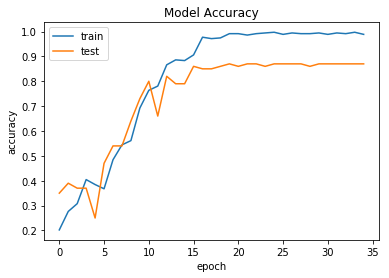

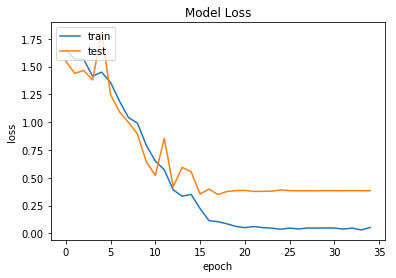

In [12]:
plt.plot(model_14.history['categorical_accuracy'])
plt.plot(model_14.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_14.history['loss'])
plt.plot(model_14.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy: 98% on training data, 87% on val data. Model is overfitting


### Saving model: Transfer learning, batch size 25, img size 80x80, frames 20

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 25
Source path =  /mnt/disks/user/project/PROJECT/Project_data/trainEpoch 1/40 ; batch size = 25



/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


25/27 [==========================>...] - ETA: 11s - loss: 1.6467 - categorical_accuracy: 0.2112Batch:  27 Index: 25


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


27/27 [==============================] - 166s 6s/step - loss: 1.6374 - categorical_accuracy: 0.2215 - val_loss: 1.7009 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2020-08-1304_41_55.773317/model-00001-1.64076-0.21870-1.70094-0.21000.h5
Epoch 2/40
27/27 [==============================] - 32s 1s/step - loss: 1.6009 - categorical_accuracy: 0.2735 - val_loss: 1.6638 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2020-08-1304_41_55.773317/model-00002-1.60094-0.27350-1.66384-0.18000.h5
Epoch 3/40
27/27 [==============================] - 32s 1s/step - loss: 1.5525 - categorical_accuracy: 0.3105 - val_loss: 1.3954 - val_categorical_accuracy: 0.4100

Epoch 00003: saving model to model_init_2020-08-1304_41_55.773317/model-00003-1.55250-0.31054-1.39538-0.41000.h5
Epoch 4/40
27/27 [==============================] - 32s 1s/step - loss: 1.3968 - categorical_accuracy: 0.3932 - val_loss: 1.3347 - val_categorical_accuracy: 0.4100

Epoch 00004

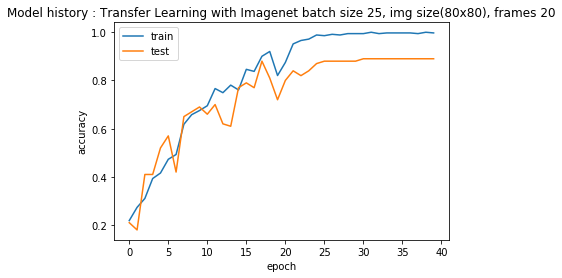

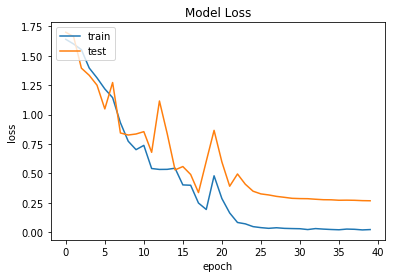

Accuracy: 99% on training data, 89% on val data. Model is overfitting

### Transfer Learning using Imagenet with MobileNet + GRU

In [13]:
from keras.applications import mobilenet
from keras.applications import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Add, Dense, Activation, TimeDistributed, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D


mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

input_shape = (20,100,100,3)
        
mobileNetModelWeight = Sequential()
mobileNetModelWeight.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


mobileNetModelWeight.add(TimeDistributed(BatchNormalization()))
mobileNetModelWeight.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModelWeight.add(TimeDistributed(Flatten()))

mobileNetModelWeight.add(GRU(256))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(128,activation='relu'))
mobileNetModelWeight.add(Dropout(0.25))

mobileNetModelWeight.add(Dense(5, activation='softmax'))


optimiser = optimizers.Adam()
mobileNetModelWeight.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (mobileNetModelWeight.summary())

17227776/17225924 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 20, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               983808    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (De

In [14]:
x = 20 # number of frames
y = 100 # image width
z = 100 # image height
batch_size = 15 #experiment with the batch size
train_generator = generator(train_path, train_doc, batch_size,x,y,z)
val_generator = generator(val_path, val_doc, batch_size,x,y,z)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, cooldown=4, verbose=1,mode='auto')# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [15]:
num_epochs =40
model_15 = mobileNetModelWeight.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 15
Source path =  Epoch 1/40
/mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 15
Batch:  7 Index: 15
45/45 [==============================] - 58s 1s/step - loss: 1.1881 - categorical_accuracy: 0.5304 - val_loss: 0.5984 - val_categorical_accuracy: 0.7200

Epoch 00001: saving model to model_init_2020-08-1710_15_23.483396/model-00001-1.17850-0.53394-0.59838-0.72000.h5
Epoch 2/40
45/45 [==============================] - 11s 235ms/step - loss: 1.1266 - categorical_accuracy: 0.6000 - val_loss: 1.2206 - val_categorical_accuracy: 0.5143

Epoch 00002: saving model to model_init_2020-08-1710_15_23.483396/model-00002-1.12656-0.60000-1.22061-0.51429.h5
Epoch 3/40
45/45 [==============================] - 12s 273ms/step - loss: 1.3643 - categorical_accuracy: 0.4593 - val_loss: 1.1840 - val_categorical_accuracy: 0.5571

Epoch 00003: saving model to model_init_2020-08-1710_15_23.483396/model-00003-1.36427-0

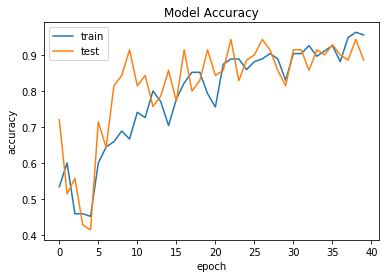

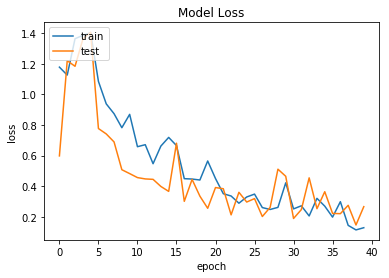

In [17]:
plt.plot(model_15.history['categorical_accuracy'])
plt.plot(model_15.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_15.history['loss'])
plt.plot(model_15.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

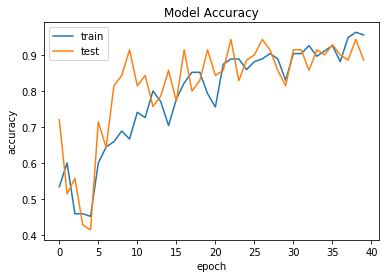

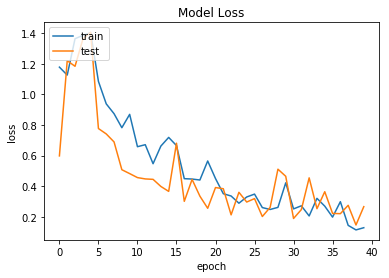

In [16]:
plt.plot(model_15.history['categorical_accuracy'])
plt.plot(model_15.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize for loss
plt.plot(model_15.history['loss'])
plt.plot(model_15.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Accuracy: 95% on training data, 94% on val data.
Trainable parameters
4,226,373


## Final Model

## Best Model is transfer learning using MobileNet Architecture & Imagenet weights. Image size 100x100, GRU layer with 256 neurons & Dense layer with 128 neurons & Dropout 0.25. LR = Auto, Frames=20, Batch Size =15, Epochs=40 has a training accuracy of 95% and Validation accuracy of 94%